In [1]:
import sklearn
import os
import pickle
import nltk
import random
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from wordcloud import WordCloud
import matplotlib.pyplot as matplot
import pandas as pd
import math
import numpy as np
from nltk.stem import WordNetLemmatizer
import requests
import tarfile

# Email Extraction
First, an EmailExtractor object must be initialized so that it can prepare the corpus.  The EmailExtractor class handles downloading and converting emails to objects.  The email zip folders are downloaded from the source and unzipped, creating folders with thousands of individual text files, each containing an email. Each file is loaded and converted to an email object that contains attributes for the subject, body, and label of the email.  The result of this step is a list of email objects.


In [2]:
class Email:
    def __init__(self):
        self.label = ""
        self.subject = ""
        self.body = ""

class EmailExtractor:
    
    def __init__(self):
        # download urls from http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/index.html
        self.CORPUS_URLS = [
            "http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/enron1.tar.gz",
            "http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/enron2.tar.gz",
            "http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/enron3.tar.gz",
            "http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/enron4.tar.gz",
            "http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/enron5.tar.gz",
            "http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/enron6.tar.gz"            
        ]
        pass
    
    # download and unzip corpus
    def download_corpus(self):
        if os.path.isdir("data"):
            print("data folder already exists!")
        else:            
            parent = os.getcwd()
            os.mkdir("data")
            os.chdir("data")
            for index,url in enumerate(self.CORPUS_URLS):            
                req = requests.get(url)
                filename = "data{num}.tar.gz".format(num=index)
                with open(filename, "wb") as file:
                    file.write(req.content)
                self.unzip(filename)
            os.chdir(parent)
        
    # used to unzip the corpus after downloading it
    def unzip(self, tar_file):
        with tarfile.open(tar_file) as tar:
            tar.extractall()
    
    # this method will loop through all the directories in a folder and extract the 
    # emails from them
    def extract_all_directory_emails(self, directory="data"):
        combined = []
        for cur_dir in os.listdir(directory):
            if os.path.isdir(os.path.join(directory,cur_dir)):
                combined+= self.extract_directory_emails(os.path.join(directory,cur_dir))
        return combined
    
    # this method extracts the emails from one directory
    def extract_directory_emails(self, directory:str):
        ham = self.load_emails(os.path.join(directory, "ham"), "ham")
        spam = self.load_emails(os.path.join(directory, "spam"), "spam")
        return ham + spam

    # once inside of a ham or spam email folder extract the individual emails
    def load_emails(self, directory:str, label:str):
        emails = []
        # looping through all the emails
        for filename in os.listdir(directory):
            # call extract_content to build the email object, initializing the subject and body
            email = self.extract_content(os.path.join(directory,filename))
            email.label = label
            emails.append(email)
        return emails

    # method to extract the subject and body from a single email
    def extract_content(self, filename:str):
        new_email = Email()
        # weird format because the files are old
        with open(filename, "r", encoding="iso-8859-15") as file:
            # the first line of every email is its subject, the rest is the body
            split = file.read().split("\n")
            new_email.subject = split[0].strip()
            new_email.body = " ".join(split[1:]).strip()
            return new_email
    
    
    

# Feature Extraction
Next, the emails are split into a training and testing set with 80% and 20% of the total emails, respectively.  Then the training emails are passed to the FeatureExtractor to train it.  The FeatureExtractor first cleans the bodies of each email to prepare them for the TFIDF Vectorizer.  Stop words such as "the" are removed from the email bodies because they don't provide any distinguishing information between emails.  The remaining words are converted to lowercase and stemmed.  Lemmatization was considered as an alternative to stemming the words, but it proved to have a negligible effect on performance and severely slowed the program's execution, so it was replaced with stemming.
Once the email bodies are prepared, they are passed to a TFIDF Vectorizer inside of the FeatureExtractor.  The TFIDF Vectorizer converts the email bodies to vectors of the TFIDF scores of the top 1000 words.  TFIDF stands for Term Frequency Inverse Document Frequency.  The TFIDF score of a particular word in an email can be computed by multiplying the relative frequency of that word in the email by the log of the ratio of all emails to emails that contain the word [2].  The TFIDF score gives greater importance to terms in an email that are uncommon throughout the rest of the corpus. Finally, the TFIDF score vectors are returned by the FeatureExtractor.


In [3]:
    
class FeatureExtractor():
    
    def __init__(self):
        self.MAX_FEATURES = 1000
        self.tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features=self.MAX_FEATURES)
        self.stop_words = set(stopwords.words("english"))
        # I noticed that Enron was one of the largest words in the tfidf worcloud so I wanted to exclude it
        # because it is so specific to this dataset.
        self.ignore_words = set(["enron"])
        self.stemmer = PorterStemmer()
        
    # method for training the FeatureExtractor
    def fit(self, emails):
        text_train = self.get_text(emails)       
        self.tfidf_vectorizer.fit(text_train)
    
    def transform(self, emails):
        texts = self.get_text(emails)
        return self.tfidf_vectorizer.transform(texts).toarray()
    
    def fit_transform(self, emails):
        text_train = self.get_text(emails)
        X = self.tfidf_vectorizer.fit_transform(text_train)
        return X
    
    # clean an individual piece of text.  Remove anything other than words.  Remove stopwords and ignored words
    # convert the remaining words to lowercase and stem them.
    def clean(self, text:str) -> str:
        valid_tokens = []
        tokens = nltk.word_tokenize(text)
        # loop through the tokens in the text and only return a string of the words not in stop_words
        # or ignore_words converted to lower case
        for token in tokens:
            if token.isalpha() and not token.lower() in self.stop_words and not token.lower() in self.ignore_words:
                stem = self.stemmer.stem(token.lower())
                valid_tokens.append(stem)
        return " ".join(valid_tokens)
    
    # method that takes a list of email objects an returns a list of email strings with the subject and email body combined
    # 
    def get_text(self, emails):
        bodies = [self.clean(email.body) for email in emails]
        return bodies
    
    # wordcloud based on the tfidf score vectors across the corpus passed in
    def plot_tfidf_wordcloud(self, emails):
        try:
            bodies = self.get_text(emails)
            # get the tfidf score matrix for the bodies
            X = self.tfidf_vectorizer.transform(bodies).toarray()
            vecs = pd.DataFrame(X.tolist(), columns = self.tfidf_vectorizer.get_feature_names())
            # sum the tfidf scores across each word to get their weight within the word cloud
            mappings = vecs.T.sum(axis=1)


            wordcloud = WordCloud(width = 3000, height = 2000).generate_from_frequencies(mappings)

            # build a matplot figure and save it to a file
            matplot.figure(figsize=(30,20))
            matplot.imshow(wordcloud, interpolation="bilinear")
            matplot.axis("off")
            matplot.margins(0,0)
    #             matplot.savefig("tfidf_wordcloud.png")
            matplot.show()
            
        except Exception:
            print("Feature Extractor hasn't been trained!")
            
    # wordcloud based on the frequencies of word across the corpus passed in
    def plot_regular_wordcloud(self, emails):
        bodies = [email.body for email in emails]
        # use CountVectorizer to get word frequency vectors for each email
        cv = CountVectorizer()
        X = cv.fit_transform(bodies)
        vecs = pd.DataFrame(X.toarray(), columns = cv.get_feature_names())
        # sum the frequencies across each word to get their weights within the word lcoud
        mappings = vecs.T.sum(axis=1)
        
        
        wordcloud = WordCloud(width = 3000, height = 2000).generate_from_frequencies(mappings) 
        # build a matplot figure and save it to a file
        matplot.figure(figsize=(30,20))
        matplot.imshow(wordcloud, interpolation="bilinear")
        matplot.axis("off")
        matplot.margins(0,0)
#         matplot.savefig("regular_wordcloud.png")
        matplot.show()

    

In [4]:
# my implementation of a Gaussian Naive Bayes classifier
# https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote05.html
class GNB:
    def __init__(self , var_correction_constant=1e-125):
        # var_correction_constant is added to every variance to prevent division by zero.
        self.var_correction_constant = var_correction_constant
        
        self.means = dict()
        self.vars = dict()
    
    # train the model, calculting the means and variances of each features for each label
    # also add the var_correction_constant to variances
    def fit(self, X, y):
        self.slice_data(X, y)
        
        for label in self.labels:
            self.means[label] = np.mean(self.data[label], axis=0, dtype=np.float64)
            self.vars[label] = np.var(self.data[label], axis=0, dtype=np.float64)
        
        for label in self.labels:
            self.vars[label] += self.var_correction_constant
    
        
    # divide X rows by their label and calculate the label probabilities
    def slice_data(self, X, y):
        X = np.array(X, dtype=np.longfloat)
        self.labels = set(y)
        self.data = dict()
        freqs = dict()
        total = 0
        # for each label save the rows correpsonding to that label in a dictionary as well as row counts
        # for the label and for the entire set
        for label in self.labels:
            self.data[label] = np.array(X[np.in1d(y, label)])
            freqs[label] = self.data[label].shape[0]
            total += self.data[label].shape[0]
    
        # calculate the probabilities of each label occuring
        self.label_probs = dict()
        for label in freqs.keys():
            self.label_probs[label] = freqs[label]/total
   
    # predict the labels of a given X matrix
    def predict(self, X):
        X = np.array(X, dtype=np.longfloat)
        probs = []
        # make predictions for each label
        for index,label in enumerate(self.labels):
            # grab the mean and variance vectors of the current label
            mean = self.means[label]
            var = self.vars[label]

            # calculate the individual feature probabilities
            # use log trick to prevent probabilities from underflowing when you multiply them all
            # explained here https://towardsdatascience.com/my-journey-into-machine-learning-class-3-c8139736f55
            feature_probs = np.log(1/np.sqrt(2*np.pi*var)) - np.square(X-mean)/(2*var)   
            
            prob = math.log(self.label_probs[label])+feature_probs.sum(axis=1)         

            probs.append((label,prob))
        
        
        combined = np.array([matrix for label, matrix in probs])
        labels = np.array([label for label, matrix in probs])
        # find the index of the label with the highest probability
        max_prob_indices = np.argmax(combined, axis=0)
        
        
        chosen_labels = labels[max_prob_indices]
        return chosen_labels 

In [5]:
class OmniClassifier:

    def __init__(self,load_dir=""):
        #Initialize OmniClassifier from pickle models
        self.models = {}
        if load_dir != "":
            self.load_models(load_dir)
        else:           
            self.models["gaussian_NB"] = GaussianNB()
            self.models["decision_tree"] = DecisionTreeClassifier()
            self.models["max_entropy"] = LogisticRegression()
            self.models["neural_net"] = MLPClassifier()
            self.models["my_NB"] = GNB()

    # method that was used to investigate hyperparameter tuning
    # there turned out to be basically no performance difference across the hyperparameters
    # I tried here
    def setup_GridCV(self):
        # doing grid searches for best params.  Probably want to get rid of this before submit
        GNB_parameters = {"var_smoothing" : [1e-7, 1e-7, 1e-9, 1e-10]}
        self.models["gaussian_NB"] = GridSearchCV(GaussianNB(), GNB_parameters)

        DTREE_parameters = {"criterion" : ["gini", "entropy"], "splitter" : ["best", "random"],
                           "min_samples_split": [2,3,4], "min_samples_leaf" : [1,2,3]}
        self.models["decision_tree"] = GridSearchCV(DecisionTreeClassifier(), DTREE_parameters)

        MAXET_parameters = {"solver": ["newton-cg", "lbfgs",  "liblinear", "sag", "saga"]}
        self.models["max_entropy"] = GridSearchCV(LogisticRegression(), MAXET_parameters)

        NN_parameters = {"activation" : ["identity", "logistic", "tanh", "relu"]}
        self.models["neural_net"] = GridSearchCV(MLPClassifier(), NN_parameters)
        
    # adds a model to the model dictionary
    def add_model(self, model_name:str, model):
        self.models[model_name] = model

    # train all models in the model dict
    def fit(self, X_train, y_train):
        for model in self.models.keys():
            self.models[model].fit(X_train, y_train)

    # load models from pickle files in a directory
    def load_models(self, directory:str="models"):
        for model in os.listdir(directory):
            self.models[os.path.splitext(model)] = pickle.load(open(os.path.join(directory, model), "rb"))
    
    # save models as pickle files in a directory
    def save_models(self, directory:str="models"):
        for model in self.models.keys():
            pickle.dump(self.models[model], open(os.path.join(directory, model+".sav"), "wb"))    

    # The next four functions simply display certain metrics for each model
    def accuracy_scores(self, X_test, y_test):
        print("Accuracy Scores:")
        print("====================================================")
        for model in self.models.keys():
            y_prediction = self.models[model].predict(X_test)
            accuracy = accuracy_score(y_test, y_prediction)
            print("{model}:{accuracy}".format(model=model, accuracy=accuracy))
        print("====================================================")

    def precision_scores(self, X_test, y_test):
        print("Precision Scores:")
        print("====================================================")
        for model in self.models.keys():
            y_prediction = self.models[model].predict(X_test)
            precision = precision_score(y_test, y_prediction, average="binary", pos_label="ham")
            print("{model}:{precision}".format(model=model, precision=precision))
        print("====================================================")

    def recall_scores(self, X_test, y_test):
        print("Recall Scores:")
        print("====================================================")
        for model in self.models.keys():
            y_prediction = self.models[model].predict(X_test)
            recall = recall_score(y_test, y_prediction, average="binary", pos_label="ham")
            print("{model}:{recall}".format(model=model, recall=recall))
        print("====================================================")
        
    def f1_scores(self, X_test, y_test):
        print("F1 Scores:")
        print("====================================================")
        for model in self.models.keys():
            y_prediction = self.models[model].predict(X_test)
            f1 = f1_score(y_test, y_prediction, average="binary", pos_label="ham")
            print("{model}:{f1}".format(model=model, f1=f1))
        print("====================================================")

    # plots all the ROC curves in one plot and save them in a file called ROC.png
    def ROC_curves(self, X_test, y_test):
        matplot.figure(figsize=(12,8))
        ax = matplot.gca()
        for model in self.models.keys():
            # my implementation of Gaussian Naive Bayes does not have the required
            # methods to work with plot_roc_curve
            if model != "my_NB":
                plot_roc_curve(self.models[model], X_test, y_test, ax=ax)
        # save the ROC curves in roc.png
        matplot.savefig("roc.png")

    # Outputs all the performance metrics at once
    def report_all(self, X_test, y_test):
        self.accuracy_scores(X_test, y_test)
        self.precision_scores(X_test, y_test)
        self.recall_scores(X_test, y_test)
        self.f1_scores(X_test, y_test)
        self.ROC_curves(X_test, y_test)


# splits the email objects into training and testing.  Defaults to an 80/20 split training/testing
def split_train_test(emails, train_threshold=0.8):
    random.shuffle(emails)
    split = int(len(emails)*0.8)
    train_emails = emails[:split]
    test_emails = emails[split:]
    return train_emails, test_emails

In [6]:
   
# this is where the results for the balanced corpus come from
def balanced_example():
    # download and extract emails
    email_extractor = EmailExtractor()
    email_extractor.download_corpus()
    # 3 to 1 ham to spam
    emails1 = email_extractor.extract_directory_emails(os.path.join("data", "enron3"))
    
    # 1 to 3 ham to spam
    emails2 = email_extractor.extract_directory_emails(os.path.join("data", "enron6"))
    
    emails = emails1 + emails2
    
    # train test split
    train_emails, test_emails = split_train_test(emails, 0.8)
    
    # extract features
    feature_extractor = FeatureExtractor()
    
    # fit feature extractor
    feature_extractor.fit(train_emails)
    
    
    X_train = feature_extractor.transform(train_emails)
    X_test = feature_extractor.transform(test_emails)
    y_train = [email.label for email in train_emails]
    y_test = [email.label for email in test_emails]
    
    # fit training data
    omniClassifier = OmniClassifier()
    omniClassifier.fit(X_train, y_train)
    
    # report results
    omniClassifier.report_all(X_test, y_test)


# this is where the results for the skewed corpus come from
def skewed_example():
    # download and extract emails
    email_extractor = EmailExtractor()
    email_extractor.download_corpus()
    # 3 to 1 ham to spam
    emails1 = email_extractor.extract_directory_emails(os.path.join("data", "enron2"))
    
    # 3 to 1 ham to spam
    emails2 = email_extractor.extract_directory_emails(os.path.join("data", "enron3"))
    
    emails = emails1 + emails2
    
    # train test split
    train_emails, test_emails = split_train_test(emails, 0.8)
    
    # extract features
    feature_extractor = FeatureExtractor()
    
    # fit feature extractor
    feature_extractor.fit(train_emails)
    
    X_train = feature_extractor.transform(train_emails)
    X_test = feature_extractor.transform(test_emails)
    y_train = [email.label for email in train_emails]
    y_test = [email.label for email in test_emails]
    
    # fit training data
    omniClassifier = OmniClassifier()
    omniClassifier.fit(X_train, y_train)
    
    # report results
    omniClassifier.report_all(X_test, y_test)
    
# full example combining every email available in the corpus
# this will take a LONG time to run and provides similar performance to the previous examples
def full_example():
    # download and extract emails
    email_extractor = EmailExtractor()
    email_extractor.download_corpus()
    emails = email_extractor.extract_all_directory_emails("data")
    
    # train test split
    train_emails, test_emails = split_train_test(emails, 0.8)
    
    # extract features
    feature_extractor = FeatureExtractor()
    
    # fit feature extractor
    feature_extractor.fit(train_emails)
    
    
    X_train = feature_extractor.transform(train_emails)
    X_test = feature_extractor.transform(test_emails)
    y_train = [email.label for email in train_emails]
    y_test = [email.label for email in test_emails]
    
    # fit training data
    omniClassifier = OmniClassifier()
    omniClassifier.fit(X_train, y_train)
    
    # report results
    omniClassifier.report_all(X_test, y_test)
    
def plot_word_clouds():
    # download and extract emails
    email_extractor = EmailExtractor()
    email_extractor.download_corpus()
    
    # 3 to 1 ham to spam
    emails1 = email_extractor.extract_directory_emails(os.path.join("data", "enron3"))
    
    # 1 to 3 ham to spam
    emails2 = email_extractor.extract_directory_emails(os.path.join("data", "enron6"))
    
    emails = emails1 + emails2
    
    # train test split
    train_emails, test_emails = split_train_test(emails, 0.8)
    
    # extract features
    feature_extractor = FeatureExtractor()
    
    # fit feature extractor
    feature_extractor.fit(train_emails)
    
    
    # plot the normal word frequency word cloud based on the words that occur the most frequently througout the training emails
    print("Regular frequency based wordcloud:")
    feature_extractor.plot_regular_wordcloud(train_emails)
    
    print("TFIDF score based wordcloud")
    # plot the word cloud based on the words with the highest average tfidf scores across the training emails
    feature_extractor.plot_tfidf_wordcloud(train_emails)
    

Accuracy Scores:
gaussian_NB:0.9496309161962657
decision_tree:0.9300911854103343
max_entropy:0.9691706469821971
neural_net:0.9622231871471993
my_NB:0.9283543204515848
Precision Scores:
gaussian_NB:0.9406113537117904
decision_tree:0.9358047016274864
max_entropy:0.9773550724637681
neural_net:0.9601063829787234
my_NB:0.9752475247524752
Recall Scores:
gaussian_NB:0.9573333333333334
decision_tree:0.92
max_entropy:0.9591111111111111
neural_net:0.9626666666666667
my_NB:0.8755555555555555
F1 Scores:
gaussian_NB:0.9488986784140969
decision_tree:0.9278350515463918
max_entropy:0.968147151188874
neural_net:0.9613848202396804
my_NB:0.9227166276346603


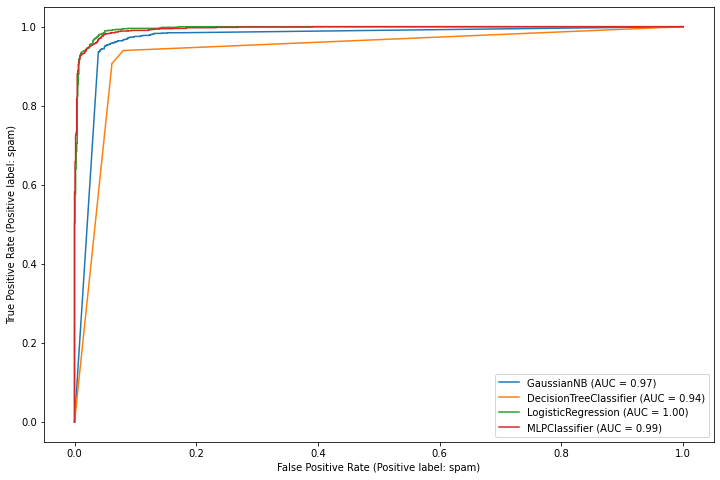

In [7]:
# run this to get the balanced example from the report
balanced_example()

data folder already exists!
Accuracy Scores:
gaussian_NB:0.9489885664028144
decision_tree:0.9406332453825857
max_entropy:0.9687774846086191
neural_net:0.9656992084432717
my_NB:0.8192612137203166
Precision Scores:
gaussian_NB:0.9785801713586292
decision_tree:0.9514903565166569
max_entropy:0.971294669009959
neural_net:0.9695193434935522
my_NB:0.9953161592505855
Recall Scores:
gaussian_NB:0.9517857142857142
decision_tree:0.969047619047619
max_entropy:0.986904761904762
neural_net:0.9845238095238096
my_NB:0.7589285714285714
F1 Scores:
gaussian_NB:0.9649969824984913
decision_tree:0.9601887348864642
max_entropy:0.9790374963094185
neural_net:0.9769639692852924
my_NB:0.8611955420466059


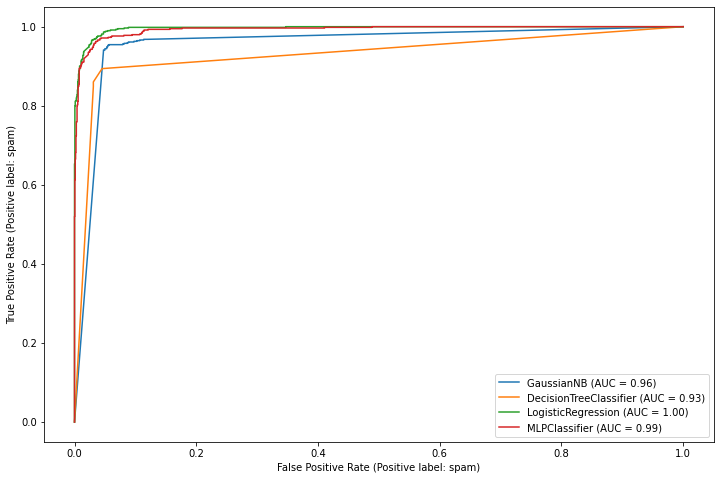

In [8]:
# run this to get the skewed example from the report
skewed_example()

data folder already exists!
Regular frequency based wordcloud:


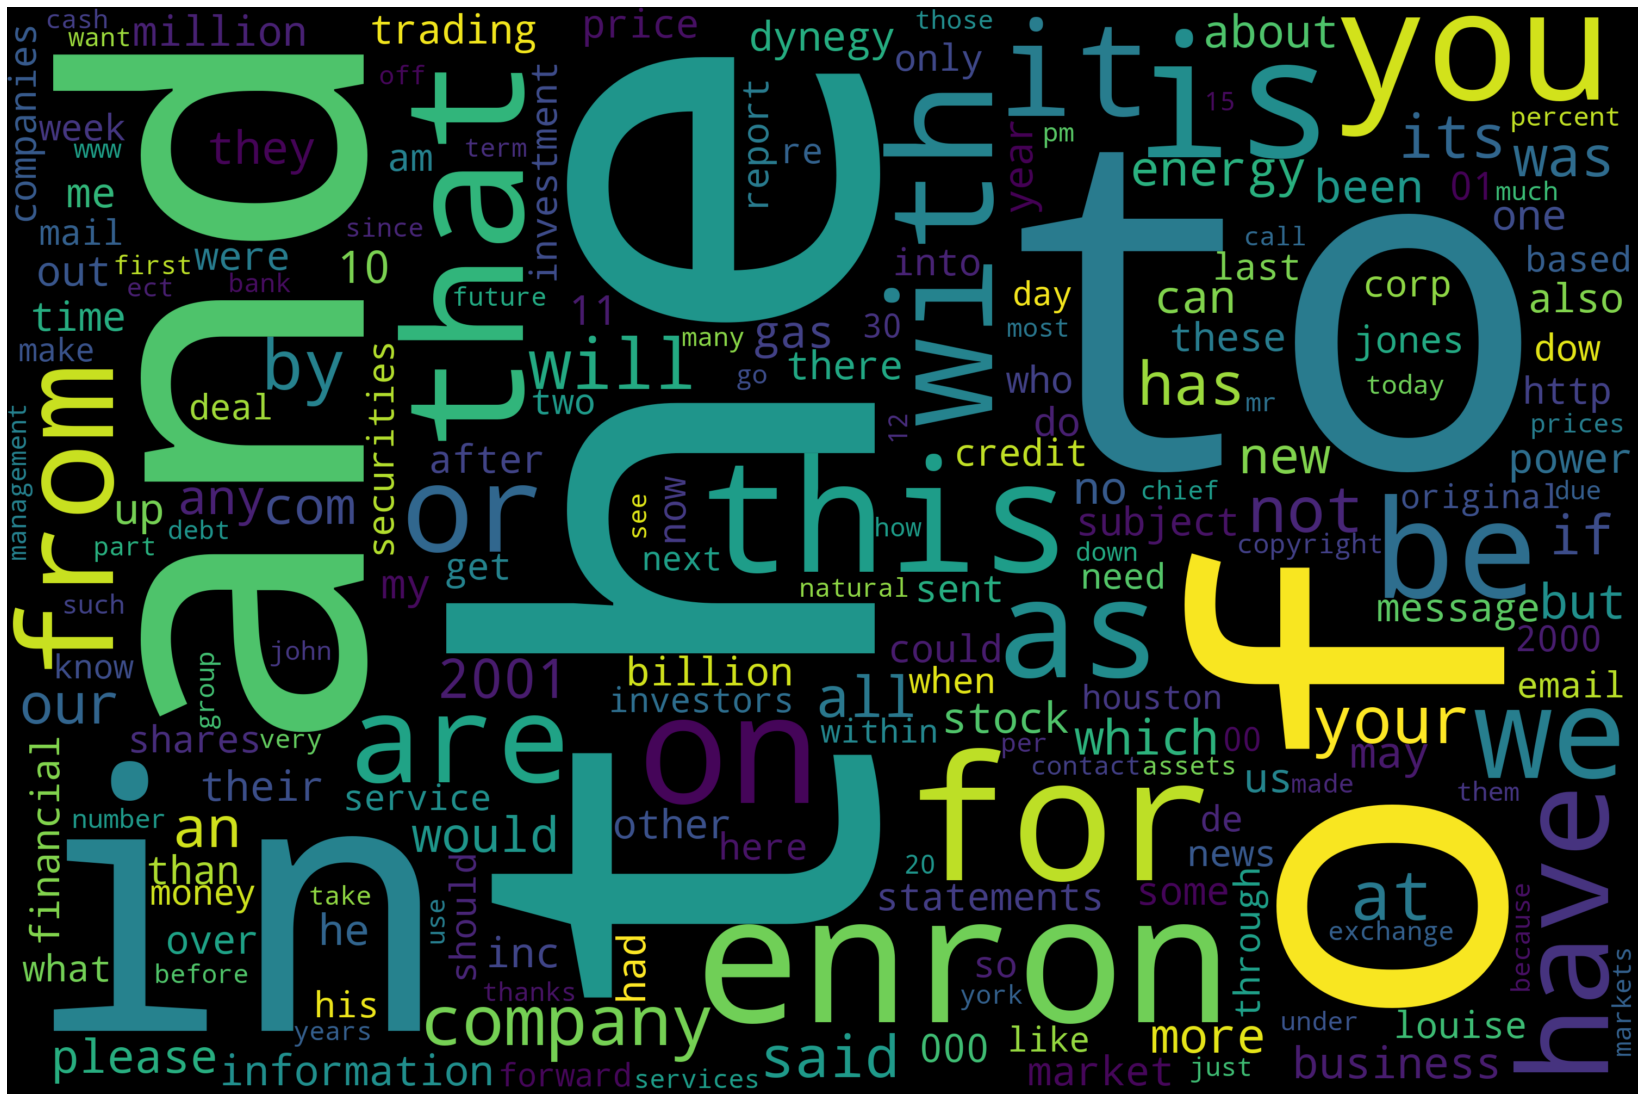

TFIDF score based wordcloud


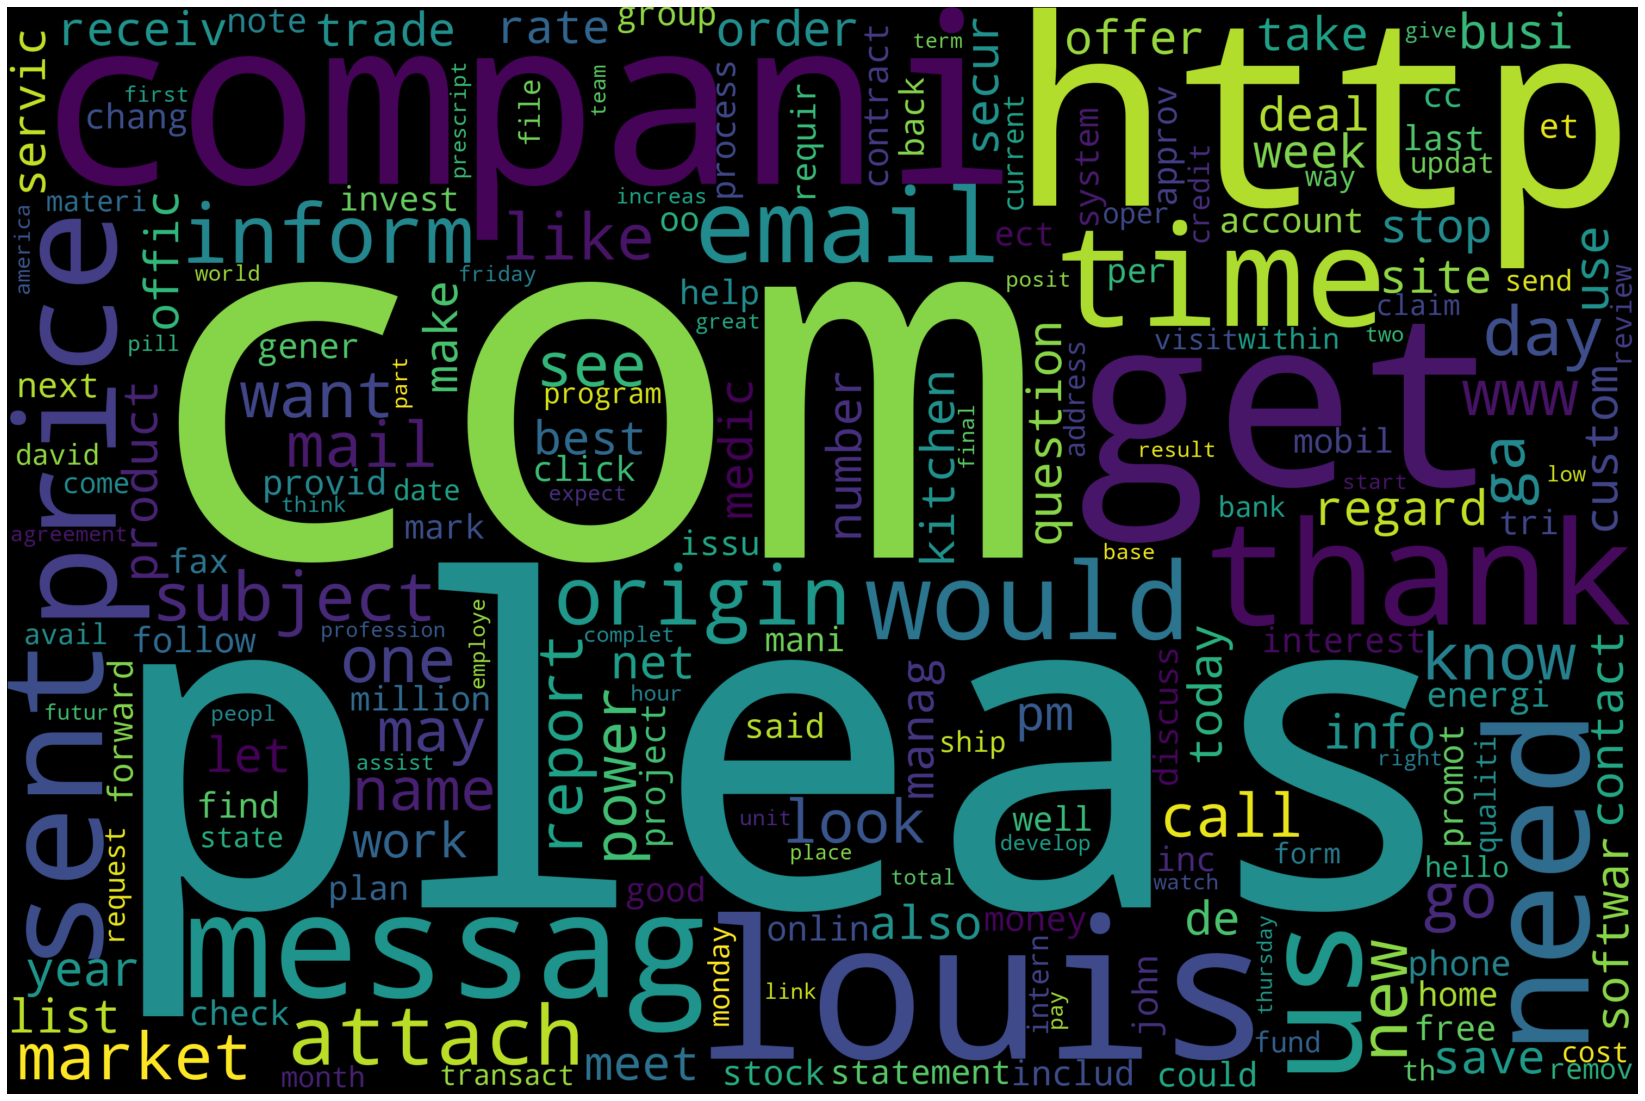

In [9]:
# run this to see some word clouds
plot_word_clouds()